# 1. Setup and Imports

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import vgg16

# 2. Load the Dataset


In [2]:
# Transformations for the input images (grayscale)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
])


# Transformations for the target images (color)
target_transform = transforms.Compose([
   transforms.ToTensor(),
       transforms.Resize((32, 32)),
])


# Custom dataset class
class ColorizationDataset(Dataset):
    def __init__(self, dataset, transform_input=None, transform_target=None):
        self.dataset = dataset
        self.transform_input = transform_input
        self.transform_target = transform_target

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        input_image, _ = self.dataset[idx]
        target_image = input_image

        if self.transform_input:
            input_image = self.transform_input(input_image)

        if self.transform_target:
            target_image = self.transform_target(target_image)

        return input_image, target_image

# Load CIFAR-10 dataset
train_dataset_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

# Splitting train dataset into train and validation
train_size = int(0.8 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset_full, [train_size, val_size])
train_dataset = ColorizationDataset(train_dataset, transform_input=transform, transform_target=target_transform)
val_dataset = ColorizationDataset(val_dataset, transform_input=transform, transform_target=target_transform)
test_dataset = ColorizationDataset(test_dataset, transform_input=transform, transform_target=target_transform)

# Apply transformations and create DataLoader for train, validation, and test sets

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,drop_last=True)
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,drop_last=True)

100%|██████████| 170498071/170498071 [00:10<00:00, 17027508.12it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
next(iter(train_loader))[1].shape

torch.Size([32, 3, 32, 32])

# 3. Define the Model Architecture


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.middle = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=1)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        logits = self.decoder(x2)
        return logits

model = UNet()

# 4. Training the Model


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#Training
num_epochs= 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data in tqdm(train_loader):
        imgs, targets = data
        imgs, targets = imgs.to(device), targets.to(device)
        targets = targets.to(torch.float32)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in validation_loader:
            imgs, targets = data
            imgs, targets = imgs.to(device), targets.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_loss /= len(validation_loader)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')




100%|██████████| 1250/1250 [01:09<00:00, 17.86it/s]


Epoch [1/10], Train Loss: 0.0866, Val Loss: 0.0379


100%|██████████| 1250/1250 [01:09<00:00, 18.00it/s]


Epoch [2/10], Train Loss: 0.0309, Val Loss: 0.0279


100%|██████████| 1250/1250 [01:09<00:00, 18.02it/s]


Epoch [3/10], Train Loss: 0.0267, Val Loss: 0.0252


100%|██████████| 1250/1250 [01:09<00:00, 18.02it/s]


Epoch [4/10], Train Loss: 0.0240, Val Loss: 0.0226


100%|██████████| 1250/1250 [01:09<00:00, 17.97it/s]


Epoch [5/10], Train Loss: 0.0222, Val Loss: 0.0218


100%|██████████| 1250/1250 [01:09<00:00, 18.00it/s]


Epoch [6/10], Train Loss: 0.0211, Val Loss: 0.0207


100%|██████████| 1250/1250 [01:09<00:00, 17.99it/s]


Epoch [7/10], Train Loss: 0.0199, Val Loss: 0.0197


100%|██████████| 1250/1250 [01:09<00:00, 18.02it/s]


Epoch [8/10], Train Loss: 0.0193, Val Loss: 0.0188


100%|██████████| 1250/1250 [01:09<00:00, 17.97it/s]


Epoch [9/10], Train Loss: 0.0187, Val Loss: 0.0181


100%|██████████| 1250/1250 [01:09<00:00, 17.97it/s]


Epoch [10/10], Train Loss: 0.0180, Val Loss: 0.0178


## 4.1 Loss function

In [6]:
class ComprehensiveLoss(nn.Module):
    def __init__(self):
        super(ComprehensiveLoss, self).__init__()
        self.crit1 = nn.MSELoss()
        self.crit2 = nn.CrossEntropyLoss()
        self.w1 = 1
        self.w2 = 1
    # define your own loss funcion or just use predefined ones

    def forward(self, input, target):
        loss1 = self.crit1(input,target)
        loss2 = self.crit2(input,target)
        totalofLoss = loss1 * self.w1 + loss2 * self.w2


        # Weights for each loss component can be adjusted
        return totalofLoss

In [7]:
# Loss function and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = ComprehensiveLoss()
model = UNet(in_channels=1, out_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# define your scheduler
# -----------------------------
# -----------------------------
# -----------------------------
# -----------------------------



In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#Training
num_epochs=10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data in tqdm(train_loader):
        imgs, targets = data
        imgs, targets = imgs.to(device), targets.to(device)
        targets = targets.to(torch.float32)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in validation_loader:
            imgs, targets = data
            imgs, targets = imgs.to(device), targets.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_loss /= len(validation_loader)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')




100%|██████████| 1250/1250 [01:09<00:00, 18.00it/s]


Epoch [1/10], Train Loss: 0.0726, Val Loss: 0.0622


100%|██████████| 1250/1250 [01:09<00:00, 18.11it/s]


Epoch [2/10], Train Loss: 0.0657, Val Loss: 0.0630


100%|██████████| 1250/1250 [01:08<00:00, 18.13it/s]


Epoch [3/10], Train Loss: 0.0625, Val Loss: 0.0628


100%|██████████| 1250/1250 [01:08<00:00, 18.12it/s]


Epoch [4/10], Train Loss: 0.0625, Val Loss: 0.0625


100%|██████████| 1250/1250 [01:09<00:00, 18.10it/s]


Epoch [5/10], Train Loss: 0.0625, Val Loss: 0.0625


100%|██████████| 1250/1250 [01:08<00:00, 18.12it/s]


Epoch [6/10], Train Loss: 0.0624, Val Loss: 0.0625


100%|██████████| 1250/1250 [01:09<00:00, 18.11it/s]


Epoch [7/10], Train Loss: 0.0624, Val Loss: 0.0626


100%|██████████| 1250/1250 [01:09<00:00, 18.05it/s]


Epoch [8/10], Train Loss: 0.0624, Val Loss: 0.0625


100%|██████████| 1250/1250 [01:09<00:00, 18.11it/s]


Epoch [9/10], Train Loss: 0.0623, Val Loss: 0.0625


100%|██████████| 1250/1250 [01:09<00:00, 18.10it/s]


Epoch [10/10], Train Loss: 0.0623, Val Loss: 0.0628


# 5. Showing Performance on Training data


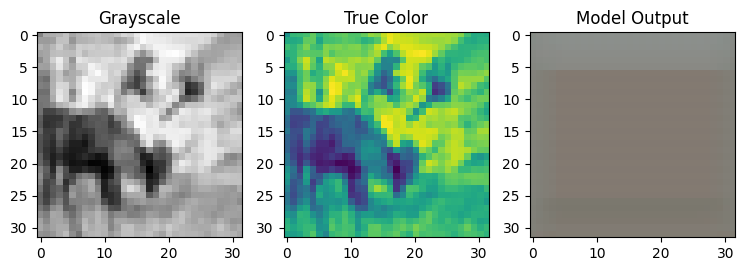

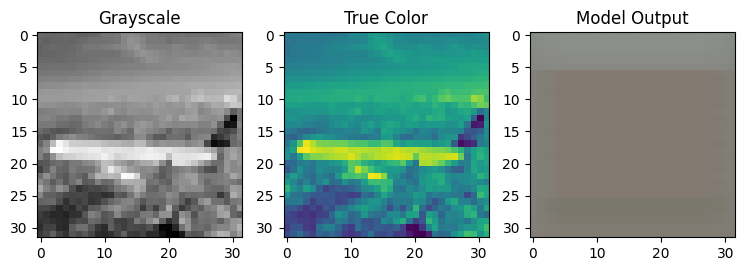

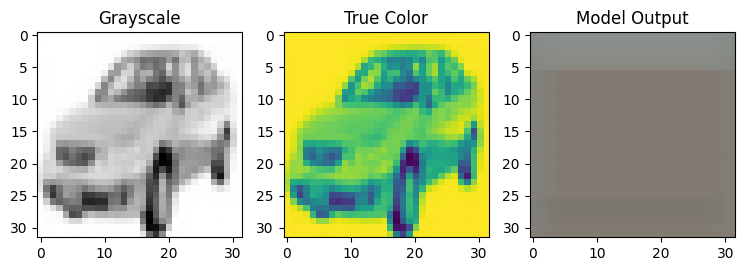

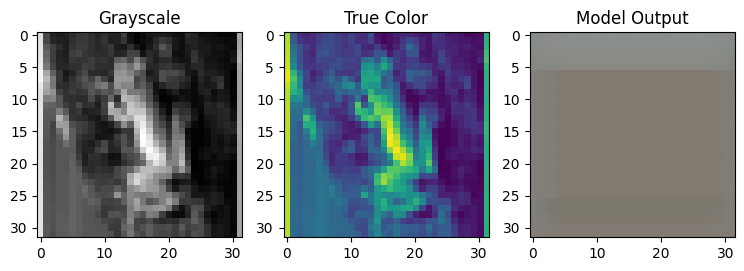

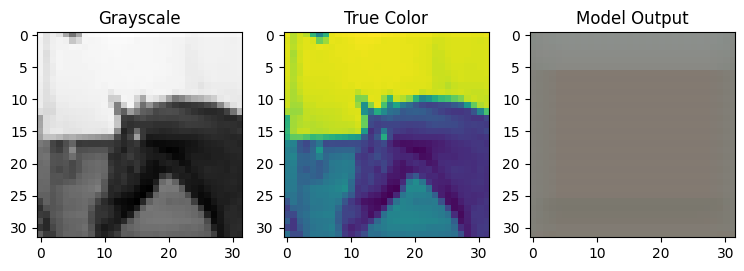

In [9]:
def visualize_colorization(model, data, device, indices):
  model.eval()
  with torch.no_grad():
        # display the images in three format: original, grayscale, and colorized

        # Visualize the first 5 images with a smaller figure size
            for i in range(5,10):
                img, _ = data[i]
                input_img = img.unsqueeze(0).to(device)
                output = model(input_img).squeeze(0).cpu()
                img = transforms.ToPILImage()(img.squeeze(0))
                #img = transforms.ToPILImage()(img)
                output = transforms.ToPILImage()(output)
                plt.figure(figsize=(9, 3))
                plt.subplot(1, 3, 1)
                plt.title('Grayscale')
                plt.imshow(img, cmap='gray')
                plt.subplot(1, 3, 2)
                plt.title('True Color')
                plt.imshow(img)
                plt.subplot(1, 3, 3)
                plt.title('Model Output')
                plt.imshow(output)
                plt.show()
random_indices = random.sample(range(len(train_dataset)), 3)
visualize_colorization(model,train_dataset,device, random_indices)

# 6. Making Inferences


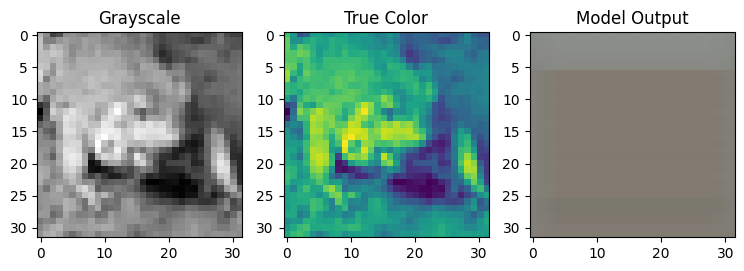

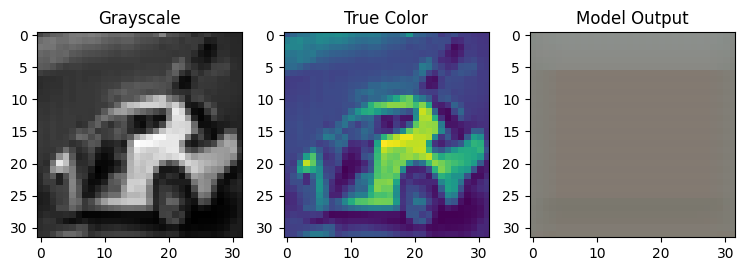

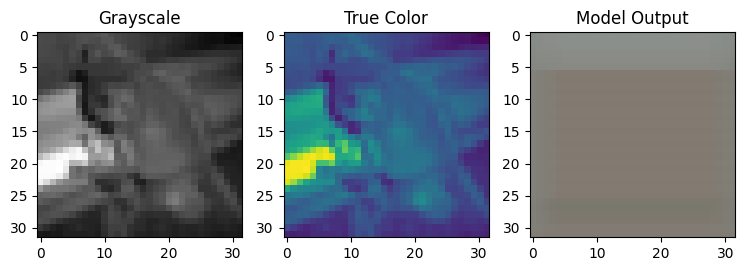

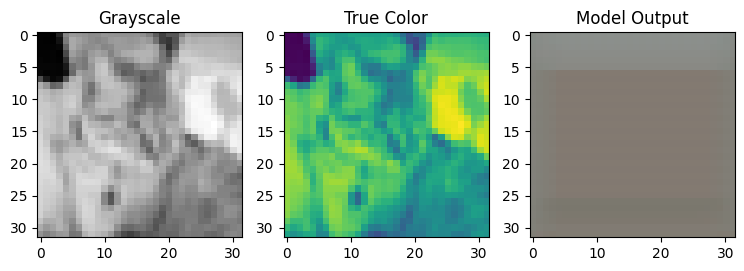

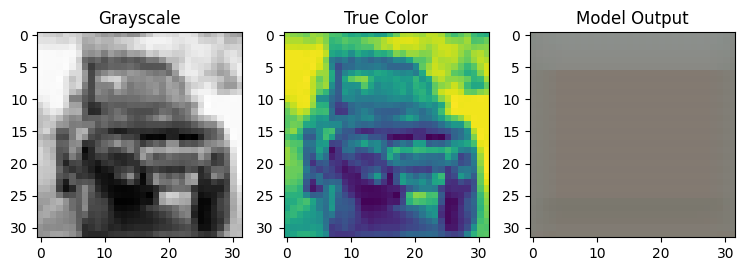

In [10]:
def visualize_colorization(model, data, device, indices):
  model.eval()
  with torch.no_grad():
        # display the images in three format: original, grayscale, and colorized

        # Visualize the first 5 images with a smaller figure size
            for i in range(5,10):
                img, _ = data[i]
                input_img = img.unsqueeze(0).to(device)
                output = model(input_img).squeeze(0).cpu()
                img = transforms.ToPILImage()(img.squeeze(0))
                #img = transforms.ToPILImage()(img)
                output = transforms.ToPILImage()(output)
                plt.figure(figsize=(9, 3))
                plt.subplot(1, 3, 1)
                plt.title('Grayscale')
                plt.imshow(img, cmap='gray')
                plt.subplot(1, 3, 2)
                plt.title('True Color')
                plt.imshow(img)
                plt.subplot(1, 3, 3)
                plt.title('Model Output')
                plt.imshow(output)
                plt.show()
random_indices = random.sample(range(len(test_dataset)), 3)
visualize_colorization(model,test_dataset,device, random_indices)